In [1]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas
from sodapy import Socrata
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon, Point

# https://geopandas.org/docs/reference/geoseries.html



apptoken = os.environ.get("SODAPY_APPTOKEN")
domain = "data.melbourne.vic.gov.au"

client = Socrata(domain, apptoken)

In [53]:
# retrieve current "On-street Parking Bay Sensors" (vh2v-4nfs) status
r1 = client.get_all('vh2v-4nfs')
df_r1 = pd.DataFrame.from_dict(r1)
# df_r1.columns

In [37]:
dcol = ['location', ':@computed_region_evbi_jbp8']
df_status = df_r1.drop(columns=dcol)
df_status

# lstDict_status = df_status.T.to_dict().values()

,bay_id,st_marker_id,status,lat,lon
0,5853,C9114,Present,-37.79839824640371,144.9647112405815
1,5878,12904N,Present,-37.79832412543489,144.96488078826815
2,5872,C9190,Unoccupied,-37.79847513739384,144.96542559059571
3,632,91W,Present,-37.80883571544522,144.97175471476578
4,5850,C9102,Unoccupied,-37.79838809150849,144.96461950098268
...,...,...,...,...,...
1050,3719,7722N,Present,-37.8033264017554,144.95290410890726
1051,3019,5100E,Unoccupied,-37.804378178842995,144.9577120543801
1052,1471,1775S,Unoccupied,-37.8167541660727,144.96609310265694
1053,3727,7762N,Unoccupied,-37.80254076503344,144.9458218122118


In [92]:
##
# Miriam did not find a complete list of parking sensors with lat / lon

# the historical annual parking sensor datasets like 4n3a-s6rn and 7pgd-bdf2
# (in tens of millions of rows) only have st marker id, but no lat lon

# guess I can get unique st marker id from historical parking sensor records
# and match the st marker id with a polygon point in crvt-b4kt (On-street Parking Bays)
# to derive this

# below some code to get these unique st marker ids a chunk at a time


In [94]:
## 000 get base list of parking sensors from '4n3a-s6rn'
## this is tens of millions of records, so use sql to group+select only needed info
r2 = client.get('4n3a-s6rn', 
                group="streetmarker",
                select="streetmarker, count(vehiclepresent)",
                limit=6000,offset=0)
r2

[{'streetmarker': '1002E', 'count_vehiclepresent': '1256'},
 {'streetmarker': '10044N', 'count_vehiclepresent': '264'},
 {'streetmarker': '10048N', 'count_vehiclepresent': '180'},
 {'streetmarker': '10049S', 'count_vehiclepresent': '12968'},
 {'streetmarker': '10051S', 'count_vehiclepresent': '13738'},
 {'streetmarker': '10053S', 'count_vehiclepresent': '6921'},
 {'streetmarker': '10055S', 'count_vehiclepresent': '14923'},
 {'streetmarker': '1006E', 'count_vehiclepresent': '3186'},
 {'streetmarker': '10100E', 'count_vehiclepresent': '1425'},
 {'streetmarker': '10102E', 'count_vehiclepresent': '1126'},
 {'streetmarker': '10103W', 'count_vehiclepresent': '2090'},
 {'streetmarker': '10105W', 'count_vehiclepresent': '1889'},
 {'streetmarker': '10107W', 'count_vehiclepresent': '1887'},
 {'streetmarker': '10111W', 'count_vehiclepresent': '1977'},
 {'streetmarker': '10113W', 'count_vehiclepresent': '1860'},
 {'streetmarker': '10115W', 'count_vehiclepresent': '1934'},
 {'streetmarker': '10116E

In [83]:
len(r2)

# df2 = pd.DataFrame.from_dict(r2)
# df2.to_csv("datasets/102_4n3a-s6rn_dl_at__20210812_sql_group_select_count.csv", index=False)

4935

In [ ]:
# found geopandas to read geojson .. seems you can do a lot in geopandas in pandas fashion
# https://geopandas.org/getting_started/introduction.html

In [2]:
## 001 read geojson into geopandas, sort 'last_edit' descending, so if I drop duplicate, I preserve latest as first
_gdf = geopandas.read_file("datasets/006_crvt-b4kt_dl_at__20210808_manual.geojson")
_gdf['last_edit'] = pd.to_datetime(_gdf['last_edit'])
_gdf = _gdf.sort_values(by='last_edit', ascending=False)
_gdf.head(3)

,rd_seg_id,marker_id,bay_id,meter_id,rd_seg_dsc,last_edit,geometry
1022,22664,None,24665,None,Intersection of Hawke Street and Ireland Street,2021-07-05 10:51:54,"MULTIPOLYGON (((144.94614 -37.80802, 144.94610..."
896,22664,None,24664,None,Intersection of Hawke Street and Ireland Street,2021-07-05 10:51:51,"MULTIPOLYGON (((144.94621 -37.80795, 144.94618..."
220,22664,None,24724,None,Intersection of Hawke Street and Ireland Street,2021-07-05 10:51:49,"MULTIPOLYGON (((144.94618 -37.80798, 144.94614..."


In [3]:
gdf = _gdf.copy()
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24715 entries, 1022 to 1108
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   rd_seg_id   23571 non-null  object        
 1   marker_id   5935 non-null   object        
 2   bay_id      24715 non-null  object        
 3   meter_id    560 non-null    object        
 4   rd_seg_dsc  23571 non-null  object        
 5   last_edit   24624 non-null  datetime64[ns]
 6   geometry    24715 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1), object(5)
memory usage: 1.5+ MB


In [26]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

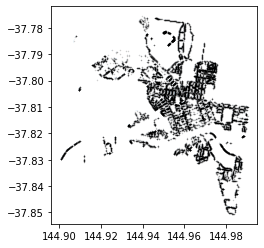

In [83]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, markersize=0.2, color="black",alpha=.2)

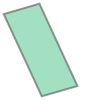

In [48]:
gdf.loc[0, "geometry"]  # index 1, geometry content = shapely geometry object of parking bay

In [50]:
gdf.loc[0,"bay_id"] 

'9590'

In [51]:
gdf.loc[0,"marker_id"] 

'4497W'

In [85]:
gdf.loc[0,"rd_seg_dsc"] 

'King Street between Lonsdale Street and Little Lonsdale Street'

In [95]:
gdf.head(1)

,rd_seg_id,marker_id,bay_id,meter_id,rd_seg_dsc,last_edit,geometry,area,centroid,distance
0,20194,4497W,9590,572B,King Street between Lonsdale Street and Little...,20201208140823,"MULTIPOLYGON (((144.95463 -37.81425, 144.95461...",1.321045e-09,POINT (144.95461 -37.81422),0.0


In [53]:
# have to work out how to set a polygon to put inside .within()

# gdf["within"] = gdf["centroid"].within(gdf)
# gdf["within"]

# https://geopandas.org/getting_started/introduction.html

# or use clip ?
# https://geopandas.org/gallery/plot_clip.html

# or .contains ? (in the order compared to .within)
# https://geopandas.org/docs/reference/api/geopandas.GeoSeries.contains.html#geopandas.GeoSeries.contains

# seems clip is more appropriate as one polygon clips a geopandas df
# as opposed to each gdf's row geometry contiains/within another gdf's row geometry

# latest Australian projection is GDA2020 .. page 18 in pdf below
# https://www.icsm.gov.au/sites/default/files/2020-01/GDA2020%20Technical%20Manual%20V1.3.pdf
# EPSG 7842 ?
# https://epsg.org/search/by-name/?query=gda2020&sessionkey=jgcdqoq3ai

In [76]:
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

capitals = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Create a subset of the world data that is just the South American continent
south_america = world[world["continent"] == "South America"]

# Create a custom polygon
polygon = Polygon([(0, 0), (0, 45), (90, 45), (120, 0), (0, 0)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

In [59]:
# capitals.crs
# world.crs
capitals.head(3)

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)


In [63]:
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


In [68]:
poly_gdf.head()

,0,geometry
0,1,"POLYGON ((0.00000 0.00000, 0.00000 90.00000, 1..."


<AxesSubplot:>

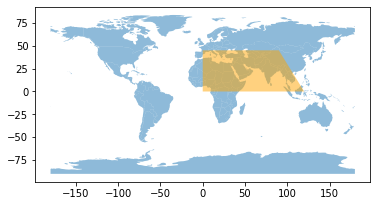

In [77]:
ax = world.plot(alpha=0.5)
poly_gdf.plot(ax=ax, color='orange', alpha=0.5)

In [ ]:
# questions
# 1. what units are used for area / distance calculated  .. and how to change units ?
# 2. how to extract point lat lon into values in columns ? .. for miriam's function + Mapbox
#      gdf['centroid'][0].x  # lon from geopandas df's centroid point x coord
#      gdf['centroid'][0].y  # lat from geopandas df's centroid point y coord
# 3a. are there duplicates in marker id rows ?
# 3b. do marker id lat lon deduced match (or close to) those on bay id we can see ?

In [435]:
## 002 get centroid from parking bay geometry, get area to check, transform/clean and get only essentials
gdf_wgs84 = _gdf.copy()
gdf_wgs84['centroid'] = gdf_wgs84.centroid
gdf_wgs84['lati'] = gdf_wgs84['centroid'].y
gdf_wgs84['long'] = gdf_wgs84['centroid'].x

gdf_7842 = gdf_wgs84.to_crs("EPSG:7842")

gdf_7842['area_m2'] = gdf_7842.area

gdf2 = gdf_wgs84.drop(columns=['bay_id','meter_id','last_edit'])
gdf3 = gdf_7842[['area_m2']]
gdf_ = pd.concat([gdf2, gdf3], axis='columns')
gdf_ = gdf_.fillna(value=np.nan)
gdf_clean = gdf_[gdf_['marker_id'].notna()]
gdf_clean = gdf_clean.drop_duplicates('marker_id')

/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [436]:
## 003 read current snapshot of parking sensors' status
r1 = client.get_all('vh2v-4nfs')
dfps = pd.DataFrame.from_dict(r1)
dfps = dfps[['bay_id','st_marker_id','status','lat','lon']]
dfps = dfps.astype({'lat':'float64', 'lon':'float64'})
dfps = dfps.rename(columns={'st_marker_id':'marker_id'})

dup2 = dfps.duplicated().sum()
len = dfps.shape[0]
print(f"removing {dup2} duplicates found in this parking sensors snapshot of {len} records")
dfps = dfps.drop_duplicates()

removing 124 duplicates found in this parking sensors snapshot of 1166 records


In [437]:
## 004 merge parking sensors base with snapshot read, handle unknown sensors
## and get new complete list of sensors with status
newgdf = gdf_clean.merge(dfps, how='outer', on="marker_id")
newgdf['lati'] = newgdf['lati'].fillna(newgdf['lat'])
newgdf['long'] = newgdf['long'].fillna(newgdf['lon'])
newgdf = newgdf.fillna(value=np.nan)
newgdf = newgdf.drop(columns=['lat','lon'])
newgdf['status'] = newgdf['status'].fillna('Unknown')
newgdf.to_csv('datasets/newgdf.csv')

In [438]:
newgdf.head(2)

,rd_seg_id,marker_id,rd_seg_dsc,geometry,centroid,lati,long,area_m2,bay_id,status
0,23247,C5010,Queen Street between Therry Street and Victori...,"MULTIPOLYGON (((144.95823 -37.80646, 144.95817...",POINT (144.95820 -37.80645),-37.806447,144.958202,9.388646,NaN,Unknown
1,23247,4999W,Queen Street between Therry Street and Victori...,"MULTIPOLYGON (((144.95807 -37.80660, 144.95801...",POINT (144.95804 -37.80659),-37.806586,144.958043,8.148094,NaN,Unknown


In [292]:
dfbase = pd.DataFrame({'seg' : [1,2,3,4,5],
                     'mid' : ['a','b','c','d','e'],
                     'status' : ['unknown','unknown','unknown','unknown','unknown'],
                     'poly' : ['a','b','c','d','e'],
                     'zeta' : ['a','b','c','d','e']})
dfbase = dfbase.set_index('mid')
dfbase

,seg,status,poly,zeta
mid,,,,
a,1,unknown,a,a
b,2,unknown,b,b
c,3,unknown,c,c
d,4,unknown,d,d
e,5,unknown,e,e


In [384]:
gdf_clean[gdf_clean['marker_id']=='C6632b']

,rd_seg_id,marker_id,rd_seg_dsc,geometry,centroid,lati,long,area_m2


In [293]:
dfp = pd.DataFrame({'bid':[9,8],
                   'mid':['b','c'],
                   'status':['p','o'],
                   'loc':[12,345]})
dfp = dfp.set_index('mid')
dfp

,bid,status,loc
mid,,,
b,9,p,12
c,8,o,345


In [294]:
dfbase.update(dfp)
dfbase

,seg,status,poly,zeta
mid,,,,
a,1,unknown,a,a
b,2,p,b,b
c,3,o,c,c
d,4,unknown,d,d
e,5,unknown,e,e


In [385]:
# if we want a heatmap, can explore and use below ?
# https://geopandas.org/gallery/plotting_with_geoplot.html

# or this ?
# https://geopandas.org/gallery/choropleths.html

# or
# https://geopandas.org/gallery/choro_legends.html



In [397]:
# following marker ids from parking sensors snapshot not in historical
# marker_id
# C6632b
# C6632a

# how should we handle this situation ?

In [ ]:
# are there any duplicate records in parking sensors snapshot ?


In [399]:
aa = pd.read_csv('datasets/003_vh2v-4nfs__bufferred.csv')